### DCGAN and Fashion_MNIST

在该实现中您可以看到如下功能：
1. GAN 的定义
2. GAN 的对抗训练
3. 生成图像的可视化

In this template you can finish the following functions:
1. Definition of GAN
2. GAN's adversarial training
3. Visualization of generated images

In [1]:
using Base.Iterators: partition
using Flux
using Flux.Optimise: update!
using Flux: logitbinarycrossentropy
using Images
using MLDatasets
using Statistics
using Parameters: @with_kw
using Printf
using Random

In [2]:
using CUDAapi, CUDAdrv, CUDAnative
gpu_id = 3  ## set < 0 for no cuda, >= 0 for using a specific device (if available)

if has_cuda_gpu() && gpu_id >=0
    device!(gpu_id)
    device = Flux.gpu
    @info "Training on GPU-$(gpu_id)"
else
    device = Flux.cpu
    @info "Training on CPU"
end

┌ Info: Training on GPU-3
└ @ Main In[2]:7


In [3]:
using Parameters: @with_kw
@with_kw mutable struct Args
    batch_size::Int = 128
    latent_dim::Int = 100
    epochs::Int = 20
    verbose_freq::Int = 1000
    output_x::Int = 6
    output_y::Int = 6
    lr_dscr::Float64 = 0.00005
    lr_gen::Float64 = 0.00005
end

Args

In [4]:
function create_output_image(gen, fixed_noise, args)
    @eval Flux.istraining() = false
    fake_images = @. cpu(gen(fixed_noise))
    @eval Flux.istraining() = true
    image_array = permutedims(dropdims(reduce(vcat, reduce.(hcat, partition(fake_images, args.output_y))); dims=(3, 4)), (2, 1))
    image_array = @. Gray(image_array + 1f0) / 2f0
    return image_array
end

create_output_image (generic function with 1 method)

In [5]:
function Discriminator()
    return Chain(
            Conv((4, 4), 1 => 64; stride = 2, pad = 1),
            x->leakyrelu.(x, 0.2f0),
            Dropout(0.25),
            Conv((4, 4), 64 => 128; stride = 2, pad = 1),
            x->leakyrelu.(x, 0.2f0),
            Dropout(0.25), 
            x->reshape(x, 7 * 7 * 128, :),
            Dense(7 * 7 * 128, 1))
end

function Generator(latent_dim)
    return Chain(
            Dense(latent_dim, 7 * 7 * 256),
            BatchNorm(7 * 7 * 256, relu),
            x->reshape(x, 7, 7, 256, :),
            ConvTranspose((5, 5), 256 => 128; stride = 1, pad = 2),
            BatchNorm(128, relu),
            ConvTranspose((4, 4), 128 => 64; stride = 2, pad = 1),
            BatchNorm(64, relu),
            ConvTranspose((4, 4), 64 => 1, tanh; stride = 2, pad = 1),
            )
end

Generator (generic function with 1 method)

In [6]:
function discriminator_loss(real_output, fake_output)
    real_loss = mean(logitbinarycrossentropy.(real_output, 1f0))
    fake_loss = mean(logitbinarycrossentropy.(fake_output, 0f0))
    return real_loss + fake_loss
end

generator_loss(fake_output) = mean(logitbinarycrossentropy.(fake_output, 1f0))

generator_loss (generic function with 1 method)

In [7]:
function train_discriminator!(gen, dscr, x, opt_dscr, args)
    noise = randn!(similar(x, (args.latent_dim, args.batch_size))) 
    fake_input = gen(noise)
    ps = Flux.params(dscr)
    # Taking gradient
    loss, back = Flux.pullback(ps) do
        discriminator_loss(dscr(x), dscr(fake_input))
    end
    grad = back(1f0)
    update!(opt_dscr, ps, grad)
    return loss
end

function train_generator!(gen, dscr, x, opt_gen, args)
    noise = randn!(similar(x, (args.latent_dim, args.batch_size))) 
    ps = Flux.params(gen)
    # Taking gradient
    loss, back = Flux.pullback(ps) do
        generator_loss(dscr(gen(noise)))
    end
    grad = back(1f0)
    update!(opt_gen, ps, grad)
    return loss
end

train_generator! (generic function with 1 method)

In [8]:
using MLDatasets
using Images
using Printf

function train(; kws...)
    # Model Parameters
    args = Args(; kws...)

    # Load FashionMNIST dataset
    images, _ = MLDatasets.FashionMNIST.traindata(Float32)
    # Normalize to [-1, 1]
    image_tensor = reshape(@.(2f0 * images - 1f0), 28, 28, 1, :)
    # Partition into batches
    data = [image_tensor[:, :, :, r] |> device for r in partition(1:60000, args.batch_size)]

    fixed_noise = [randn(args.latent_dim, 1) |> device for _=1:args.output_x*args.output_y]

    # Discriminator
    d_model = Discriminator() |> device

    # Generator
    g_model = Generator(args.latent_dim) |> device

    # Optimizers
    opt_dscr = ADAM(args.lr_dscr)
    opt_gen = ADAM(args.lr_gen)

    # Training
    train_steps = 0
    for ep in 1:args.epochs
        @info "Epoch $ep"
        for x in data
            # Update discriminator and generator
            loss_dscr = train_discriminator!(g_model, d_model, x, opt_dscr, args)
            loss_gen = train_generator!(g_model, d_model, x, opt_gen, args)

            if train_steps % args.verbose_freq == 0
                @info("Train step $(train_steps), Discriminator loss = $(loss_dscr), Generator loss = $(loss_gen)")
                # Save generated fake image
#                 output_image = create_output_image(g_model, fixed_noise, args)
#                 display(output_image)
#                 save(@sprintf("dcgan_steps_%06d.png", train_steps), output_image)
            end
            train_steps += 1
        end
    end

    output_image = create_output_image(g_model, fixed_noise, args)
    display(output_image)
#     save(@sprintf("dcgan_steps_%06d.png", train_steps), output_image)
end

train (generic function with 1 method)

┌ Info: Epoch 1
└ @ Main In[8]:31
┌ Info: Train step 0, Discriminator loss = 1.4381738, Generator loss = 0.70620656
└ @ Main In[8]:38
┌ Info: Epoch 2
└ @ Main In[8]:31
┌ Info: Epoch 3
└ @ Main In[8]:31
┌ Info: Train step 1000, Discriminator loss = 1.203705, Generator loss = 0.8882565
└ @ Main In[8]:38
┌ Info: Epoch 4
└ @ Main In[8]:31
┌ Info: Epoch 5
└ @ Main In[8]:31
┌ Info: Train step 2000, Discriminator loss = 1.3487449, Generator loss = 0.754305
└ @ Main In[8]:38
┌ Info: Epoch 6
└ @ Main In[8]:31
┌ Info: Epoch 7
└ @ Main In[8]:31
┌ Info: Train step 3000, Discriminator loss = 1.450408, Generator loss = 0.6517055
└ @ Main In[8]:38
┌ Info: Epoch 8
└ @ Main In[8]:31
┌ Info: Epoch 9
└ @ Main In[8]:31
┌ Info: Train step 4000, Discriminator loss = 1.3254168, Generator loss = 0.8234496
└ @ Main In[8]:38
┌ Info: Epoch 10
└ @ Main In[8]:31
┌ Info: Epoch 11
└ @ Main In[8]:31
┌ Info: Train step 5000, Discriminator loss = 1.3110251, Generator loss = 0.80107075
└ @ Main In[8]:38
┌ Info: Epoch 12

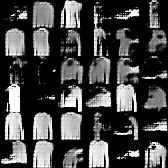

In [9]:
train()